<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.
##### Traducción a español y fixes Eduardo H. Ramirez

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Redes Generativas Adversariales Convolucionales (DCGANS)

Cuaderno original: https://www.tensorflow.org/tutorials/generative/dcgan

En este cuaderno se incluyen algunas modificaciones para correr en Google Colab con Python 3.7

## Ejercicio

Experimenta con más épocas de entrenamiento y con el parámetro noise_dim y comenta el efecto en las imágenes sintéticas generadas.

- EPOCHS = 50
- noise_dim = 100


Este tutorial demuestra cómo generar imágenes de dígitos escritos a mano utilizando una [Red Generativa Adversarial Convolucional](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). El código está escrito utilizando el [API secuencial de Keras](https://www.tensorflow.org/guide/keras) con un ciclo de entrenamiento basado en `tf.GradientTape`.

### 1. Inicialización

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
# To generate GIFs
!pip install imageio

#No funciona en Colab, usar funcion embebida
#!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 2. Preparación del dataset



In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. Creación de modelos

Tanto el generador como el discriminador son definidos utilizando el [API secuencial de Keras](https://www.tensorflow.org/guide/keras#sequential_model).

### Generador

El generador utiliza capas de *upsampling* mediante `tf.keras.layers.Conv2DTranspose` para producir una imagen a partir de una semilla aleatoria. 

Se inicia el proceso con una capa densa (`Dense`) que toma esta semilla como input, después se lleva a cabo el upsampling múltiples veces hasta que se obtiene el tamaño deseado de 28x28x1. 

Notar que se utiliza la función de activación `tf.keras.layers.LeakyReLU` para cada capa, excepto para la última, ya que utiliza `tanh`.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Con el siguiente código puedes generar una imagen con la red aún no entrenada. 


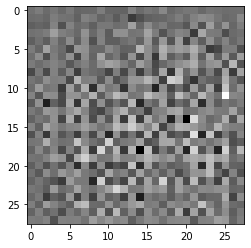

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminador

El discriminador es un clasificador CNN como los que ya hemos estudiado previamente.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Puedes utilizar el discriminador sin entrenamiento para clasificar una imagen como real o falsa. 

El modelo será entrenado para generar valores positivos para imágenes reales y valores negativos para imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0033988]], shape=(1, 1), dtype=float32)



## Funciones de pérdida y optimizadores

En esta sección se definen las funciones de pérdida y optimizadores para ambos modelos.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida del discriminador

Este método cuantifica qué tan bien el discriminador es capaz de distinguir imágenes reales de falsas. Compara las predicciones del discriminador sobre imágenes reales contra un arreglo de 1's y las predicciones sobre imágenes falsas contra un arreglo de 0's.


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador

La pérdida del generador cuantifica qué tan bien fue capaz de engañar al discriminador. 

El generador se desempeña bien si el discriminador clasifica las imágenes falsas como reales.

Por lo tanto, se comparan las decisiones del discriminador sobre las imágenes generadas contra un arreglo de 1's.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores del generador y del discriminador son diferentes, ya que cada red se entrena de forma independiente.



In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints

Puedes guardar y restaurar checkpoints de modelos con el siguiente fragmento. Esta técnica es útil en caso de entrenamientos muy largos que sean interrumpidos.


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 4. Definición del ciclo de entrenamiento


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El ciclo de entrenamiento comienza con el generador recibiendo una semilla aleatoria como input. Dicha semilla es utilizada para producir una imagen. Luego, el discriminador es utilizado para clasificar imágenes reales (obtenidas del training set) y falsas imágenes (producidas por el generador). Se calcula la pérdida para cada uno de estos modelos y se actualizan los modelos utilizando sus respectivos gradientes. Notar que se crea un gradientTape para cada modelo.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


**Generar y guardar imágenes**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenamiento del modelo

Se utiliza el método `train()` definido arriba para entrenar el generador y discriminador simultáneamente. 

Como ya lo hemos mencionado, el entrenamiento de las GAN's puede ser difícil, ya que es importante que el generador y el discriminador no se dominen, sino que aprendan a una velocidad similar.

Al inicio del entrenamiento, las imágenes generadas se ven como ruido aleatorio, conforme progresa el entrenamiento los dígitos se verán cada vez más reales.

Después de 50 épocas aproximadamente se asemejan bastante a los dígitos de la base MNIST. 

El proceso de entrenamiento toma menos de un minuto por época de acuerdo a la configuración de Colab.

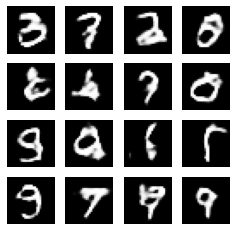

In [ ]:
train(train_dataset, EPOCHS)


Restaurar el último checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Creación de un GIF animado.


In [ ]:
# Desplegar una imagen por cada época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

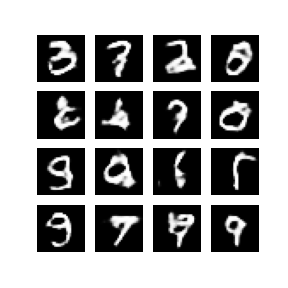

In [ ]:
display_image(EPOCHS)

Utilizar `imageio` para crear un gif animado con todas las imágenes generadas en el entrenamiento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import sys
sys.version

'3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]'

In [ ]:
#EHR
# Fix para correr en Colab con Python 3.7, definir funciones embebidas
# sin depender del modulo de tensorflow_doc

import base64
import mimetypes
import os
import pathlib
import textwrap
import IPython.display

def embed_data(mime: str, data: bytes) -> IPython.display.HTML:
  """Embeds data as an html tag with a data-url."""
  b64 = base64.b64encode(data).decode()
  if mime.startswith('image'):
    tag = f'<img src="data:{mime};base64,{b64}"/>'
  elif mime.startswith('video'):
    tag = textwrap.dedent(f"""
        <video width="640" height="480" controls>
          <source src="data:{mime};base64,{b64}" type="video/mp4">
          Your browser does not support the video tag.
        </video>
        """)
  else:
    raise ValueError('Images and Video only.')
  return IPython.display.HTML(tag)

def embed_file(path: os.PathLike) -> IPython.display.HTML:
  """Embeds a file in the notebook as an html tag with a data-url."""
  path = pathlib.Path(path)
  mime, unused_encoding = mimetypes.guess_type(str(path))
  data = path.read_bytes()

  return embed_data(mime, data)



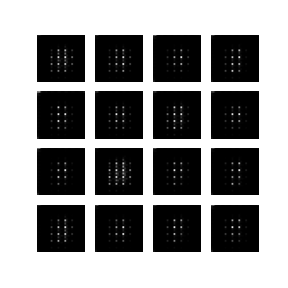

In [ ]:
embed_file(anim_file)

## Siguientes pasos


En este tutorial has podido completar los pasos necesarios para escribir y entrenar una GAN.

Te recomendamos experimentar con un dataset diferente, por ejemplo el de rostros de celebridades que está [disponible en Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). 

Para aprender más sobre GANs te recomendamos el tutorial de [NIPS 2016](https://arxiv.org/abs/1701.00160).
